# PMFs and CDFs

<text color=purple>The first step is to run the author's code to import all of the data and store it in preg and resp data frames.</text>

In [1]:
from __future__ import print_function, division
import sys
import numpy as np
import thinkstats2
from collections import defaultdict

def CleanFemPreg(df):
    df.agepreg /= 100.00
    df.loc[df.birthwgt_lb > 20, 'birthwgt_lb'] = np.nan
    na_vals = [97, 98, 99]
    df.birthwgt_lb.replace(na_vals, np.nan, inplace=True)
    df.birthwgt_oz.replace(na_vals, np.nan, inplace=True)
    df.hpagelb.replace(na_vals, np.nan, inplace=True)
    df.babysex.replace([7,9], np.nan, inplace=True)
    df.nbrnaliv.replace([9], np.nan, inplace=True)
    df['totalwgt_lb']=df.birthwgt_lb + df.birthwgt_oz/16.0
    df.cmintvw = np.nan

def ReadFemPreg(dct_file='2002FemPreg.dct',
                dat_file='2002FemPreg.dat.gz'):
    dct=thinkstats2.ReadStataDct(dct_file)
    df=dct.ReadFixedWidth(dat_file, compression='gzip')
    CleanFemPreg(df)
    return df

def ReadFemResp(dct_file='2002FemResp.dct', 
                dat_file='2002FemResp.dat.gz',
                nrows=None):
    dct = thinkstats2.ReadStataDct(dct_file)
    df = dct.ReadFixedWidth(dat_file, compression='gzip',
                            nrows=nrows)
    return df

def MakePregMap(df):
    d = defaultdict(list)
    for index, caseid in df.caseid.iteritems():
        d[caseid].append(index)
    return d

def ValidatePregnum(resp, preg):
    preg_map = MakePregMap(preg)
    for index, pregnum in resp.pregnum.iteritems():
        caseid = resp.caseid[index]
        indices = preg_map[caseid]
        if len(indices) != pregnum:
            print(caseid, len(indices), pregnum)
            return False
    return True

resp=ReadFemResp()
assert(len(resp) == 7643)
assert(resp.pregnum.value_counts()[1] == 1267)
preg = ReadFemPreg()
assert len(preg) == 13593
assert preg.caseid[13592] == 12571
assert preg.pregordr.value_counts()[1] == 5033
assert preg.nbrnaliv.value_counts()[1] == 8981
assert preg.babysex.value_counts()[1] == 4641
assert preg.birthwgt_lb.value_counts()[7] == 3049
assert preg.birthwgt_oz.value_counts()[0] == 1037
assert preg.prglngth.value_counts()[39] == 4744
assert preg.outcome.value_counts()[1] == 9148
assert preg.birthord.value_counts()[1] == 4413
assert preg.agepreg.value_counts()[22.75] == 100
assert preg.totalwgt_lb.value_counts()[7.5] == 302
weights = preg.finalwgt.value_counts()
key = max(weights.keys())
assert preg.finalwgt.value_counts()[key] == 6
assert(ValidatePregnum(resp, preg))

<text color=purple>Then I need to import the packages that I will be using. I will also limit the preg data frame to the columns needed and clear out pregnancies that did not result in a live birth. Lastly, I will create a function to label all of my graphs.</text>

In [2]:
import matplotlib.pyplot as plt
from empiricaldist import Pmf, Cdf
from scipy import stats
import random

preg2 = preg[['caseid', 'prglngth', 'outcome', 'pregordr', 'birthord',
              'totalwgt_lb', 'agepreg', 'finalwgt']]
preg= preg2[preg2.outcome == 1]

def label_plot(title,xlabel,ylabel):
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

### Exercise 3-1

Something like the class size paradox appears if you survey children and ask how many children are in their family. Families with many children are more likely to appear in your sample, and families with no children have no chance to be in the sample.

Use the NSFG respondent variable NUMKDHH to construct the actual distribution for the number of children under 18 in the household.

Now compute the biased distribution we would see if we surveyed the children and asked them how many children under 18 (including themselves) are in their household.

Plot the actual and biased distributions, and compute their means.

<text color=purple>To calculate a distribution based on the childrens' experiences, I need to make sure that each child's experience is listed separately. I will duplicate the number based on the family (i.e. "2" will become "2, 2" and "5" will become "5, 5, 5, 5, 5"). I will also remove all of the 0's as there are no children to experience that situation. Then plot and label both sets of data.</text>

The true mean for number of children in a household is:  1.024205155043831


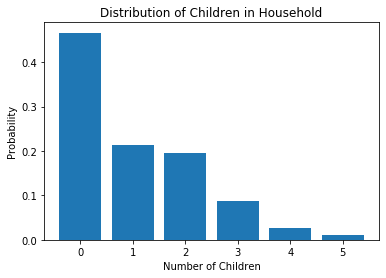

In [3]:
real_values = resp['numkdhh'].tolist()
real_pmf = Pmf.from_seq(real_values)
real_pmf.bar()
label_plot('Distribution of Children in Household', 
           'Number of Children', 'Probability')
print('The true mean for number of children in a household is: ', 
      real_pmf.mean())

The biased mean for number of children in a household is:  2.403679100664282


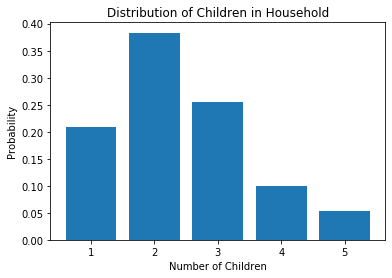

In [4]:
bias_values = resp['numkdhh'].tolist()
for i in range(0,len(bias_values)):
    num_copies = 1
    while num_copies < bias_values[i]:
        bias_values.append(bias_values[i])
        num_copies += 1
bias_values2 = [i for i in bias_values if i != 0]
bias_pmf = Pmf.from_seq(bias_values2)
bias_pmf.bar()
label_plot('Distribution of Children in Household', 
           'Number of Children', 'Probability')
print('The biased mean for number of children in a household is: ', 
      bias_pmf.mean())

### Exercise 3-2

In “Summarizing Distributions” on page 22 we computed the mean of a sample by adding up the elements and dividing by n. If you are given a PMF, you can still compute the mean, but the process is slightly different. Similarly, you can compute variance like this.

Write functions called PmfMean and PmfVar that take a Pmf object and compute the mean and variance. To test these methods, check that they are consistent with the methods Mean and Var provided by Pmf.

In [5]:
def PmfMean(test_pmf):
    my_testp = test_pmf.ps
    my_testx = test_pmf.qs
    test_total = float(0)
    for i in range (0, len(my_testx)):
        test_total += my_testp[i] * my_testx[i]
    test_mean = test_total
    return test_mean

def PmfVar(test_pmf):
    # calculate mean of values
    my_testp = test_pmf.ps
    my_testx = test_pmf.qs
    test_mean = my_testx.mean()

    # calculate variance of pmf
    test_var = 0
    for i in range (0, len(my_testx)):
        my_temp = my_testx[i] - test_mean
        test_var += (my_temp ** 2) * my_testp[i]
    return test_var

my_list=[]
for x in range (0,50):
    my_list.append(random.random())
my_pmf = Pmf.from_seq(my_list)
my_mean = PmfMean(my_pmf)
my_var = PmfVar(my_pmf)
real_mean = my_pmf.mean()
real_var = my_pmf.var()

print ('My mean from the pmf is: ', my_mean)
print ('The real mean is : ', real_mean)
print ('My variance from the pmf is: ', my_var)
print ('The real variance is: ', real_var)

My mean from the pmf is:  0.4712215690253462
The real mean is :  0.4712215690253461
My variance from the pmf is:  0.06481968416721613
The real variance is:  0.06481968416721615


### Exercise 4-1

How much did you weigh at birth? If you don’t know, call your mother or someone else who knows. Using the NSFG data (all live births), compute the distribution of birth weights and use it to find your percentile rank. If you were a first baby, find your percentile rank in the distribution for first babies. Otherwise use the distribution for others. If you are in the 90th percentile or higher, call your mother back and apologize.

<text color=purple>I am adopted, so I have no way of knowing that information. I asked a friend if she knew the birthweights of her children, and she gave them to me. I randomly chose one which turned out to be 9 pounds 8 ounces (or 9.5 pounds) for her fourth child.</text>

In [6]:
all_birth_weights = preg['totalwgt_lb'].tolist()
p_rank = stats.percentileofscore(all_birth_weights,9.5)
print ('The percentile rank of 9.5 pounds is : ', p_rank)

The percentile rank of 9.5 pounds is :  94.62724092697857


C:\Users\Agent\Anaconda3\lib\site-packages\scipy\stats\stats.py:1942: RuntimeWarning: invalid value encountered in less
  left = np.count_nonzero(a < score)
C:\Users\Agent\Anaconda3\lib\site-packages\scipy\stats\stats.py:1943: RuntimeWarning: invalid value encountered in less_equal
  right = np.count_nonzero(a <= score)


### Exercise 4-2

The numbers generated by random.random are supposed to be uniform between 0 and 1; that is, every value in the range should have the same probability. 

Generate 1000 numbers from random.random and plot their PMF and CDF. Is the distribution uniform?

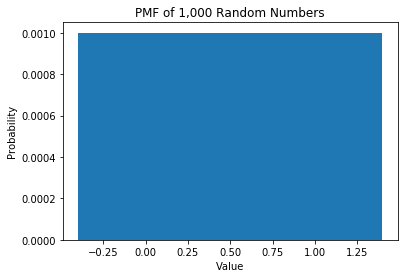

In [7]:
my_nums = []
for x in range (0,1000):
    my_nums.append(random.random())

my_pmf = Pmf.from_seq(my_nums)
my_pmf.normalize()
my_pmf.bar()
label_plot('PMF of 1,000 Random Numbers','Value','Probability')

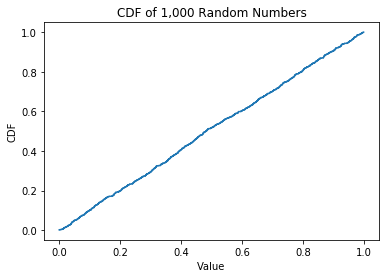

In [8]:
my_cdf = Cdf.from_seq(my_nums)
my_cdf.step()
label_plot('CDF of 1,000 Random Numbers','Value','CDF')